In [ ]:
# %pip install pytorch-lightning

In [1]:
import sys
import os

def is_colab_env():
    return "google.colab" in sys.modules

def mount_google_drive(drive_dir="/content/drive/", repo_dir="MyDrive/repositories/deepfake-detection"):
    # mount google drive
    from google.colab import drive
    drive.mount(drive_dir)

    # change to correct working directory
    import os
    repo_dir = f"{drive_dir}{repo_dir}"
    os.chdir(repo_dir)
    print(os.listdir()) # verify content
    return repo_dir

def resolve_path(levels_deep=3):
    if is_colab_env():
        return mount_google_drive()
    else:
        # Get the directory of the current script
        current_dir = os.path.dirname(os.path.abspath('__file__'))

        # Construct the path to the parent directory
        for i in range(levels_deep):
            current_dir = os.path.dirname(current_dir)

        # Add the parent directory to sys.path
        sys.path.append(current_dir)
        print(sys.path)
        return current_dir

proj_dir = resolve_path()

['c:\\Users\\jinxy\\anaconda3\\envs\\df-env\\python312.zip', 'c:\\Users\\jinxy\\anaconda3\\envs\\df-env\\DLLs', 'c:\\Users\\jinxy\\anaconda3\\envs\\df-env\\Lib', 'c:\\Users\\jinxy\\anaconda3\\envs\\df-env', '', 'c:\\Users\\jinxy\\anaconda3\\envs\\df-env\\Lib\\site-packages', 'c:\\Users\\jinxy\\anaconda3\\envs\\df-env\\Lib\\site-packages\\win32', 'c:\\Users\\jinxy\\anaconda3\\envs\\df-env\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\jinxy\\anaconda3\\envs\\df-env\\Lib\\site-packages\\Pythonwin', 'g:\\My Drive\\repositories\\deepfake-detection']


In [21]:
import config
import numpy as np
from PIL import Image
import cv2

face_cascade = cv2.CascadeClassifier(proj_dir + '/data/haarcascade_frontalface_default.xml'
)

In [4]:
# pytorch
import torch
import pytorch_lightning as L

In [5]:
# import local dependencies
from src.models.resnet import ResNetClassifier
from src.transforms.fusion import get_fused_transform

In [6]:
model_id = "dwt_rgb_resnet18"
model_checkpoint_dir = f"{proj_dir}/{config.CHECKPOINTS_DIR}/{model_id}"

In [7]:
seed = config.SEED

# Set seeds for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)

# Determine device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [8]:
# define model
checkpoint = "lightning_logs/version_0/checkpoints/epoch=13-step=177520.ckpt"
deepfake_detector = ResNetClassifier.load_from_checkpoint(
    checkpoint_path=f"{model_checkpoint_dir}/{checkpoint}",
    in_channels=7,
    freeze_features=False,
    weights_only=False
    )

In [9]:
# Set the model to evaluation mode
deepfake_detector.eval()

ResNetClassifier(
  (model): ResNet(
    (conv1): Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [22]:
def get_cropped_face(img_data, crop_factor=1.1):
    """
    Detects a face in an image and returns the cropped face as a NumPy array.

    :param img_data: The input image as a NumPy array (BGR format).
    :param crop_factor: Factor to extend the bounding box.
    :return: A NumPy array representing the cropped BGR face, or None if no face is found.
    """
    img = img_data
    if img is None or img.size == 0:
        print("Error: Empty image data provided.")
        return None

    # 1. Convert to grayscale for detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Detect faces
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )

    if len(faces) == 0:
        print("No face detected.")
        return None

    # 3. Crop the largest face (assuming the main subject is the largest face)
    (x, y, w, h) = sorted(faces, key=lambda f: f[2] * f[3], reverse=True)[0]

    # 4. Apply a 'crop factor' for padding
    center_x = x + w // 2
    center_y = y + h // 2
    size = int(max(w, h) * crop_factor)

    # Calculate the coordinates for the padded square crop
    x_start = max(0, center_x - size // 2)
    y_start = max(0, center_y - size // 2)
    x_end = min(img.shape[1], center_x + size // 2)
    y_end = min(img.shape[0], center_y + size // 2)

    # Adjust start/end if clipping occurred to ensure a square crop
    final_size = min(x_end - x_start, y_end - y_start)

    # Final Crop
    cropped_face = img[y_start : y_start + final_size, x_start : x_start + final_size]

    return cropped_face

In [23]:
# Get your transformation function
dwt_rgb_transforms = get_fused_transform()

# Load a new image as PIL Image
new_image_pil = Image.open(proj_dir + "/samples/fake_4.jpg")

# Convert PIL Image (RGB) to NumPy array (BGR) for OpenCV
new_image_np_rgb = np.array(new_image_pil)
new_image_np_bgr = cv2.cvtColor(new_image_np_rgb, cv2.COLOR_RGB2BGR)

# Process the image: get cropped face as NumPy array (BGR)
cropped_face_np_bgr = get_cropped_face(new_image_np_bgr)

# Check if face was detected
if cropped_face_np_bgr is None:
    # Handle the case where no face was found
    raise ValueError("No face detected in the image.")

# Convert the cropped NumPy array (BGR) back to PIL Image (RGB) for torchvision transforms
cropped_face_pil_rgb = Image.fromarray(cv2.cvtColor(cropped_face_np_bgr, cv2.COLOR_BGR2RGB))

# Apply the transformations
transformed_input = dwt_rgb_transforms['test'](cropped_face_pil_rgb)

# Add a batch dimension and move to the appropriate device
input_tensor = transformed_input.unsqueeze(0).to(device)

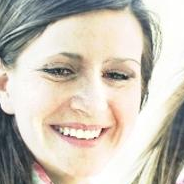

In [24]:
cropped_face_pil_rgb

In [25]:
with torch.no_grad(): # Disable gradient calculations for faster inference
    output = deepfake_detector(input_tensor)

    # Apply sigmoid to convert logits to probabilities
    probabilities = torch.sigmoid(output)

    # Get the predicted class (0 for Real, 1 for Fake, depending on your setup)
    prediction = (probabilities > 0.5).long()

print(f"Output Logits: {output.item()}")
print(f"Probability of being Fake: {probabilities.item()}")
print(f"Predicted Class: {prediction.item()}")
print(f"Prediction: {"Fake" if prediction.item() == 1 else "Real"}")

Output Logits: 5.669024467468262
Probability of being Fake: 0.9965606331825256
Predicted Class: 1
Prediction: Fake
